# Data exploration (PU)

Visual exploration of the input data.

In [53]:
import uproot
import numpy as np
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.plotting import get_event_window

ds_name = "CloseByGamma200PUFull"
file_name = "new_ntuples_15410634_194.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)
print("NTracksters:", tracksters["NTracksters"].array())
print("NSimTracksters:", simtracksters["stsSC_NTracksters"].array())

Events per file: 10
NTracksters: [3138, 3060, 3533, 3767, 3083, 3180, 2803, 2775, 3250, 3264]
NSimTracksters: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [54]:
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})
clusters_x = clusters["position_x"].array()
clusters_y = clusters["position_y"].array()
clusters_z = clusters["position_z"].array()
clusters_e = clusters["energy"].array()

# Plot everything within a cylinder (PU)

This belongs to Approach.

In [55]:
eid = 0
tid = 0

vi = tracksters["vertices_indexes"].array()[eid]
vx = ak.Array([clusters_x[eid][indices] for indices in vi])
vy = ak.Array([clusters_y[eid][indices] for indices in vi])
vz = ak.Array([clusters_z[eid][indices] for indices in vi])
ve = ak.Array([clusters_e[eid][indices] for indices in vi])

bx = tracksters["barycenter_x"].array()[eid]
by = tracksters["barycenter_y"].array()[eid]
bz = tracksters["barycenter_z"].array()[eid]

svi = simtracksters["stsSC_vertices_indexes"].array()[eid]
svx = ak.Array([clusters_x[eid][indices] for indices in svi])
svy = ak.Array([clusters_y[eid][indices] for indices in svi])
svz = ak.Array([clusters_z[eid][indices] for indices in svi])
sve = ak.Array([clusters_e[eid][indices] for indices in svi])

all_z = list(sorted(set(svz[tid])))
x_coords = {z: [] for z in all_z}
y_coords = {z: [] for z in all_z}
layer_e = {z: [] for z in all_z}

for x, y, z, e in zip(svx[tid], svy[tid], svz[tid], sve[tid]):
    x_coords[z].append(x)   
    y_coords[z].append(y)
    layer_e[z].append(e)

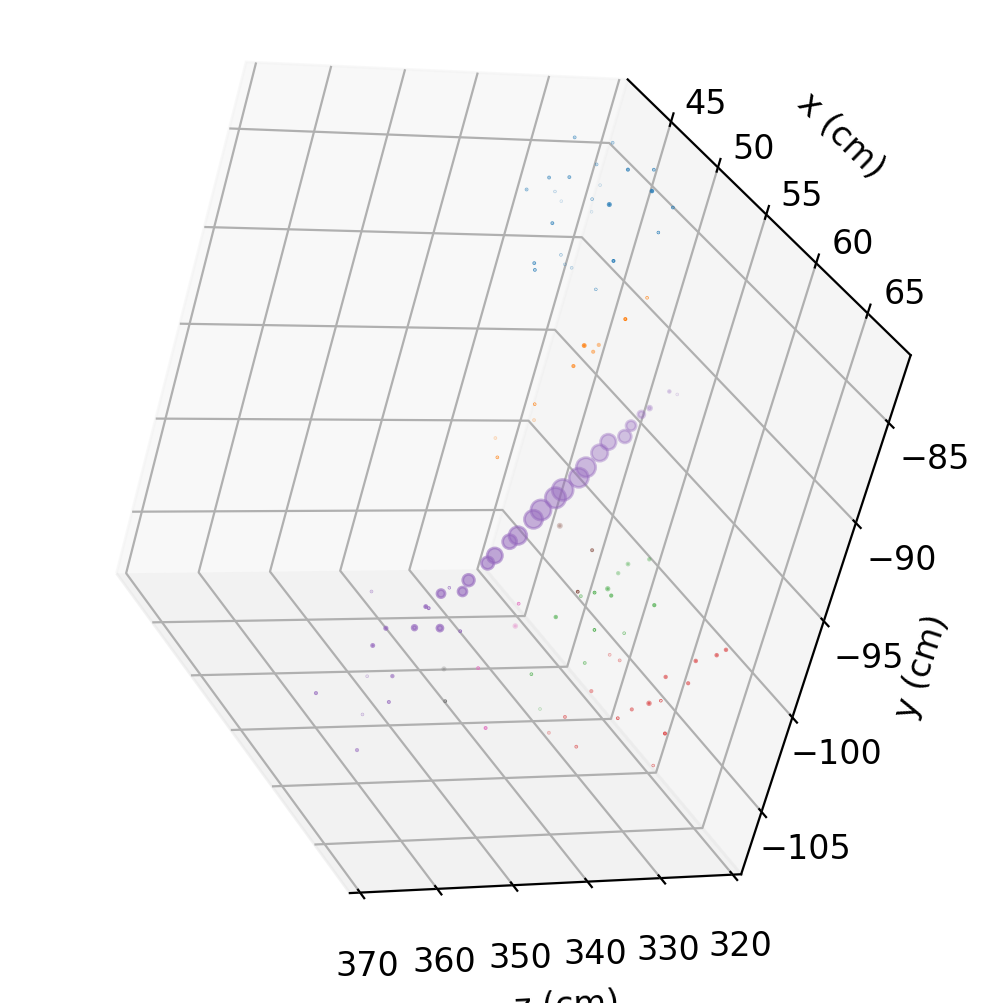

In [56]:
# XXX: this is not a real cylinder, see "get_tracksters_in_cone" method

PLOT_TH = 10

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.set_zlabel("z (cm)")


for tx, ty, tz, te, tbx, tby, tbz in zip(vx, vy, vz, ve, bx, by, bz):
    plot = False

    # loop through layer-clusters
    for x, y, zm, e in zip(tx, ty, tz, te):
        if zm not in x_coords:
            # if out of the simtrackster scope
            continue

        xm = np.mean(x_coords[zm])
        ym = np.mean(y_coords[zm])

        # if planear distance is too small
        dst = np.sqrt((xm - x)**2 + (ym - y)**2)
        if dst < PLOT_TH:
            plot = True
            break
    if plot:
        ax.scatter(tx, ty, tz, s=te)

# ax.scatter(x_avg, y_avg, all_z, s=np.array(e_sum))
ax.view_init(30, 30, 90)
plt.show()

## Selection

select a trackster having at least 50% of the simtrackster energy an is above 10GeV

In [61]:
scores_above_50 = []
scores_below_50 = []
shared_dists = []
shared_dist_reco = []

for eid in range(3):
    raw_energy = tracksters["raw_energy"].array()[eid]
    sim_raw_energy = simtracksters["stsSC_raw_energy"].array()[eid]
    print(f"Event {eid} - total tracksters: {len(raw_energy)}, above 10 GeV: {sum(raw_energy > 10)}, non-zero shared energy:")

    reco2sim_index = np.array(associations["tsCLUE3D_recoToSim_SC"].array()[eid])
    reco2sim_shared = np.array(associations["tsCLUE3D_recoToSim_SC_sharedE"].array()[eid])
    reco2sim_score = np.array(associations["tsCLUE3D_recoToSim_SC_score"].array()[eid])

    # for each reco trackster
    for recoT_idx, (sim_indexes, shared_energies, scores) in enumerate(zip(reco2sim_index, reco2sim_shared, reco2sim_score)):
        # get the shared energy with all simm tracksters
        for simT_idx, shared_energy, score in zip(sim_indexes, shared_energies, scores):
            rt_e = raw_energy[recoT_idx]
            if shared_energy > 0 and score < 0.2:
                st_e = sim_raw_energy[simT_idx]
                fr = shared_energy / st_e
                if fr > 0.5:
                    scores_above_50.append(score)
                else:
                    shared_dists.append(fr)
                    shared_dist_reco.append(shared_energy / rt_e)
                    scores_below_50.append(score)
                print(f"\tsimE: {st_e:.3f}\trecoE: {rt_e:.3f}\tshared: {shared_energy:.3f}\tscore: {score:.4f}")

Event 0 - total tracksters: 3138, above 10 GeV: 289, non-zero shared energy:
	simE: 599.849	recoE: 573.144	shared: 568.930	score: 0.0000
	simE: 599.849	recoE: 1.616	shared: 1.616	score: 0.0000
	simE: 599.849	recoE: 1.384	shared: 1.384	score: 0.0000
	simE: 599.849	recoE: 0.849	shared: 0.849	score: 0.0000
Event 1 - total tracksters: 3060, above 10 GeV: 306, non-zero shared energy:
	simE: 517.324	recoE: 2.892	shared: 1.703	score: 0.1324
	simE: 517.324	recoE: 484.284	shared: 469.632	score: 0.0005
	simE: 517.324	recoE: 3.183	shared: 1.660	score: 0.0922
	simE: 517.324	recoE: 2.951	shared: 2.185	score: 0.0279
	simE: 517.324	recoE: 1.711	shared: 1.475	score: 0.1406
Event 2 - total tracksters: 3533, above 10 GeV: 368, non-zero shared energy:
	simE: 289.374	recoE: 272.427	shared: 256.308	score: 0.0013
	simE: 289.374	recoE: 4.854	shared: 2.488	score: 0.1458


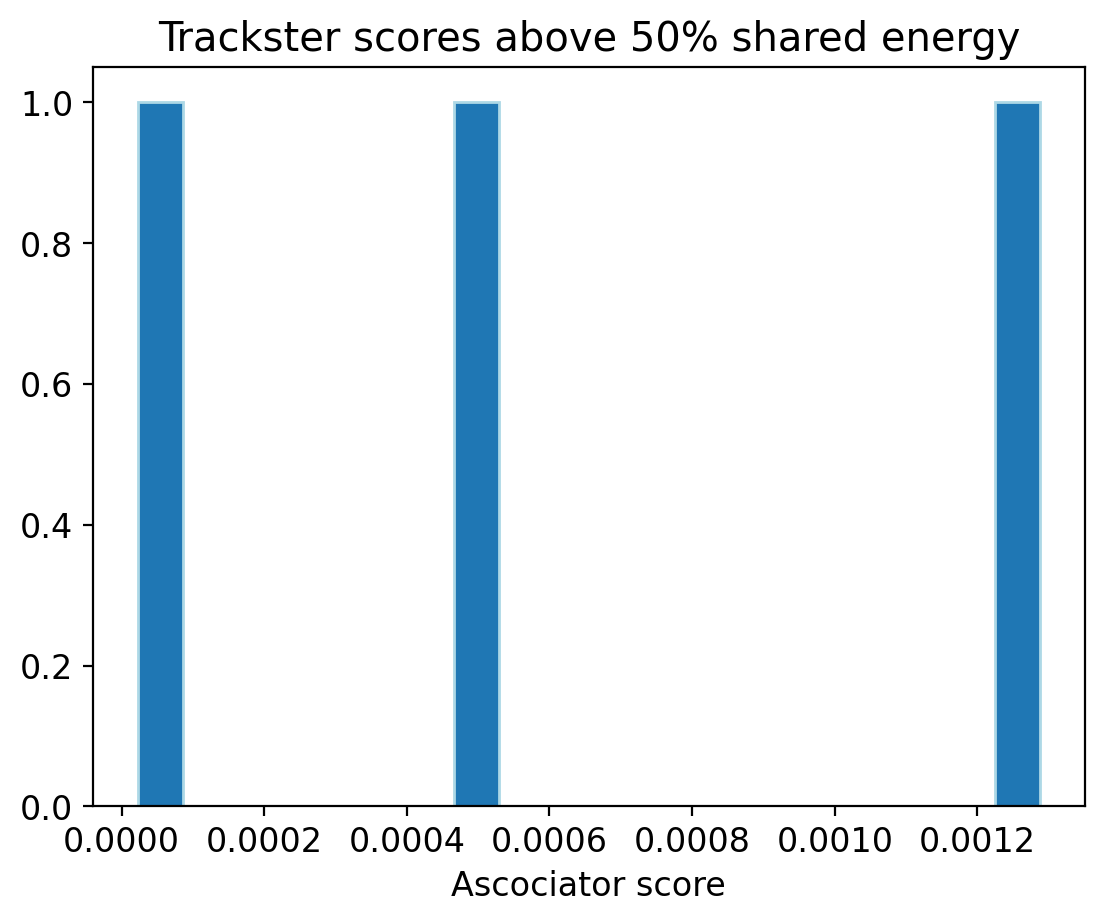

In [62]:
plt.title("Trackster scores above 50% shared energy")
plt.hist(scores_above_50, bins=20, edgecolor="lightblue")
plt.xlabel("Ascociator score")
plt.show()

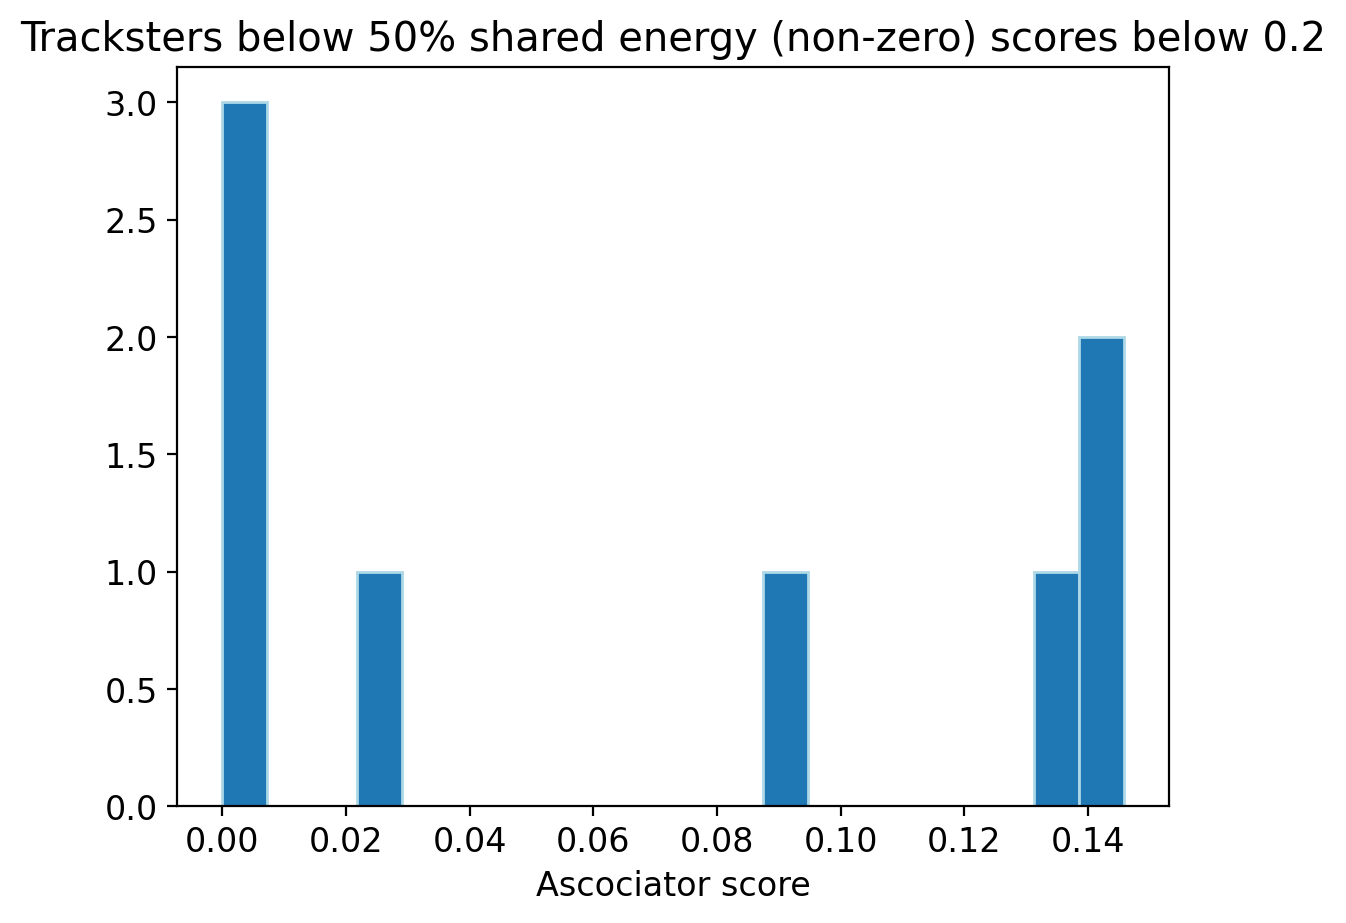

In [63]:
plt.title("Tracksters below 50% shared energy (non-zero) scores below 0.2")
plt.hist(scores_below_50, bins=20, edgecolor="lightblue")
plt.xlabel("Ascociator score")
plt.show()

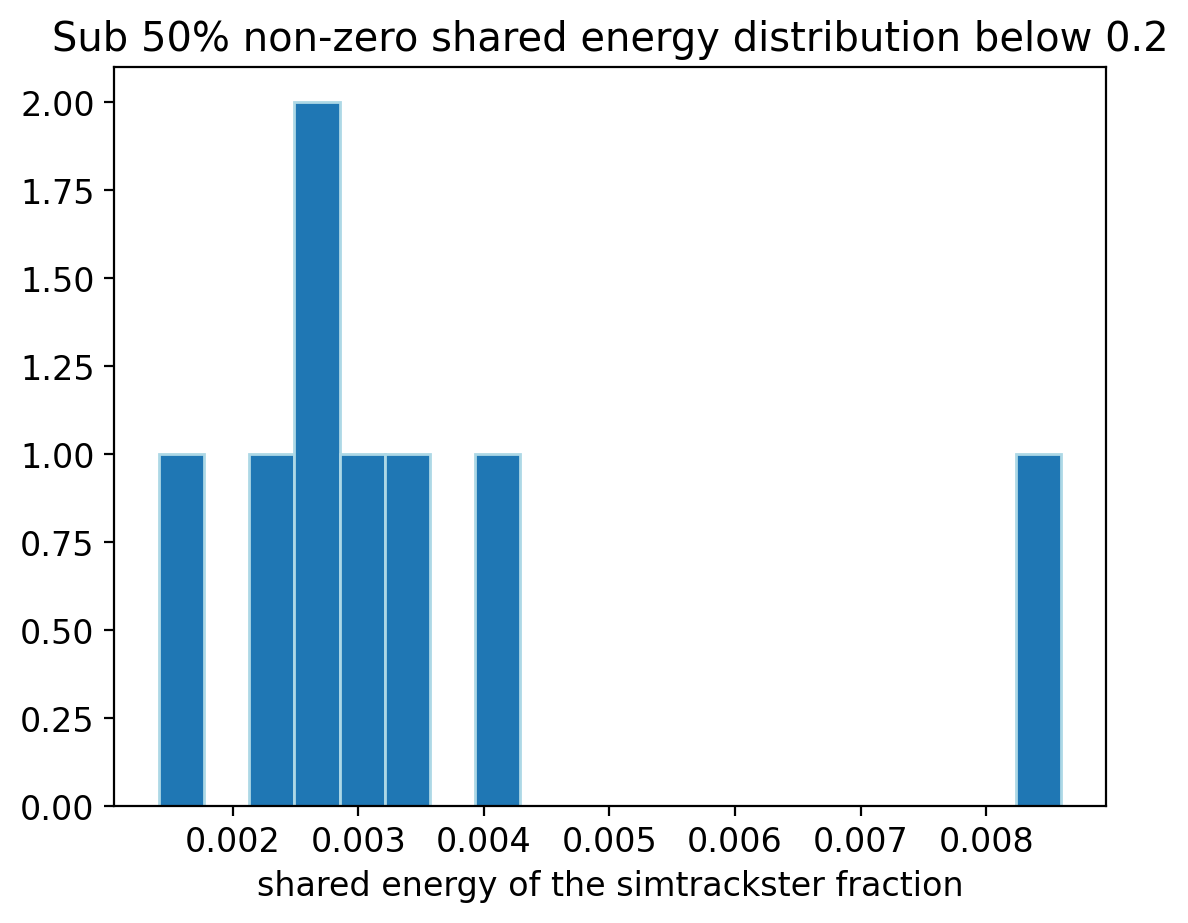

In [64]:
plt.title("Sub 50% non-zero shared energy distribution below 0.2")
plt.hist(shared_dists, bins=20, edgecolor="lightblue")
plt.xlabel("shared energy of the simtrackster fraction")
plt.show()

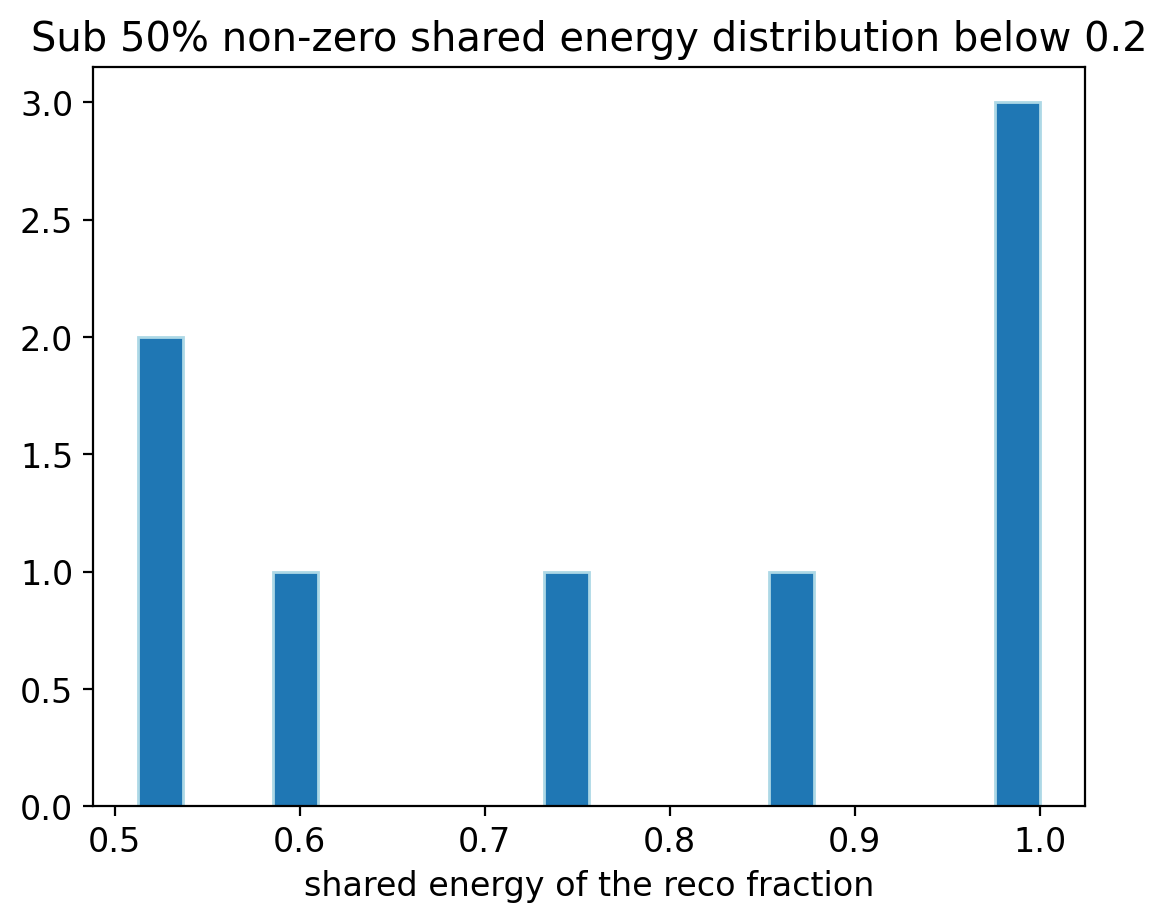

In [65]:
plt.title("Sub 50% non-zero shared energy distribution below 0.2")
plt.hist(shared_dist_reco, bins=20, edgecolor="lightblue")
plt.xlabel("shared energy of the reco fraction")
plt.show()